# **Sales Volume Forecasting**

Final Project

Batch : RMT-025

========================================

Project Team :

1. David Tjoe (Data Analyst)

2. Aumedi Wibisana (Data Engineer and Data Scientist)

3. Wahyuni Rahmawati (Data Scientist)


========================================

<center><img src="https://raw.githubusercontent.com/wahyunirahmawati/data/main/image.jpg" height=500, width=1000></img></centerleft>

# Objective

Forecasting production volumes is a critical aspect of business planning and operations management. By accurately predicting the demand for our products, we can optimize our production processes, manage inventory levels efficiently, and make informed decisions about resource allocation.

One effective method for forecasting production volumes is by utilizing sales values.

In this project, we focused on improving the inventory planning process of an anonymous company in Q1 2024. This anonymous company acts as a product distributor by purchasing office products from manufacturers, holding them and then reselling them to retailers and end-users.

By analyzing their office products' purchases, sales and product details data, we created a data model that makes predictions of predicted sales quantities
Knowing how much will be sold of each product category in the future can help determine how much of each product category should be ordered or kept in stock at any given time.

Having a tool that assists in determining the ideal inventory levels at any given time is crucial to:

- Meet customer demand and ensure customer satisfaction
- Avoid having too much inventory which can lead to unnecessary storage and handling costs
- Avoid stockouts which can result in sales loss and/or fines from customers
- Maintain high profitability

For predicting future sales volumes, we will comparing three models, SARIMAX, LSTM, and Linear Rgression then we will choose one model with the best evaluation result and deploy it in to web app.


**Target Users of Data Model**

The target users for this model are:

- the anonymous company whose data was analyzed as well as other distributors, manufacturers or retailers that depend on predicting future sales for goods procurement
- all product sales planning, supply chain, and procurement professionals.

**Data Sources**
- The data used for this project comes in the form of CSV files obtained from the anonymous company.
- The original data has been anonymized for the purposes of this project.
- The CSVs contain 5-years worth of data (2018 to 2022) for Purchases, Sales as well as Product Details.


# Import Libraries

In [4]:
# pip install hvplot

In [5]:
# Import Libraries
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import hvplot.pandas
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from IPython.display import display
from pathlib import Path
from datetime import datetime
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import scipy.stats as scs

from pylab import rcParams
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from keras.preprocessing.sequence import TimeseriesGenerator  # modeling LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Importing everything from forecasting quality metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

import pickle # save model

# Data Loading

In [6]:
# Read the sales data

df_product = pd.read_csv("https://raw.githubusercontent.com/FTDS-assignment-bay/p2-final-project-ftds-025-rmt-group-001/main/dataset/PRODUCTS.csv")
df_sales = pd.read_csv("https://raw.githubusercontent.com/FTDS-assignment-bay/p2-final-project-ftds-025-rmt-group-001/main/dataset/SALES.csv")

In [7]:
df_product.head()

,Part_No,Description,Category,Vendor No,Available,On Hand,Current Cost,Volume (inch^3),Length (UDF),Width (UDF),Height (UDF),Weight (UDF),Product Code,Pallet Quantity (Incoming Max) (UDF),Pallet Length (inches) (UDF),Pallet Width (inches) (UDF)
0,111MedPol009R,Med. Pile Polycarbonate 9Mat 40x40,Polycarbonate Chair Mat,MANU123,0,0,39.59700,840.5,41.0,41.0,0.5,6.0,MATS,100,62,50
1,111MedPol9RBL,Med.Pile Poly 9Mat 40x40 Blue,Polycarbonate Chair Mat,MANU123,13,13,36.68120,840.5,41.0,41.0,0.5,6.0,MATS,100,62,50
2,111MedPol09RC,Med.Pile Poly 9Mat 40x40 Cerise,Polycarbonate Chair Mat,MANU123,0,0,38.62101,840.5,41.0,41.0,0.5,6.0,MATS,100,62,50
3,111MedPol23LR,Med. Pile Polycarbonate 48x53 w/lip,Polycarbonate Chair Mat,MANU123,3,3,51.41580,1347.5,47.0,12.0,12.0,11.0,MATS,100,62,48
4,111AllPol23ER,All Carpet Polycarbonate 60'x60',Polycarbonate Chair Mat,MANU123,2,2,88.64100,14400.0,60.0,14.0,14.0,17.0,MATS,15,62,50


In [8]:
df_sales.head()

,Unit_Price,Invoice_Date,Order_Qty,Ship_Qty,B/O,Extended_price,U/M,Margin_%_(Current),Currency,Product_Code,Part_No,PO_No,Customer_No,Invoice_No
0,33.95,43102,1,1,0,33.95,EA,38,NaN,MATS,123HarPVC20LV,CA100436839,WAYFAR,301833
1,101.90,43104,1,1,0,101.90,EA,58,NaN,MATS,FPRPreEnt72CH,64242622,STAPLESDS,302672
2,50.20,43109,2,2,0,100.40,EA,58,NaN,MATS,FCOCoAnt36BK,64286923,STAPLESDS,302946
3,130.00,43111,2,2,0,260.00,EA,45,NaN,MATS,111AllPol23ER,177671,G&THOO,302517
4,84.70,43111,4,4,0,338.80,EA,41,NaN,MATS,111MedPol23ER,64322719,STAPLES,302514


In [9]:
# Display the shape
df_sales.shape

(67288, 14)

In [10]:
# Convert the datatype
df_sales['Invoice_Date']=df_sales['Invoice_Date'].astype(int)

# Display the datatype
df_sales['Invoice_Date'].dtype

dtype('int64')

In [11]:
# Convert the dates in 'Invoice_Date' column to the datetime format
for i in range(0, len(df_sales['Invoice_Date'])):
   df_sales['Invoice_Date'][i] = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + df_sales['Invoice_Date'][i] - 2)

In [12]:
# Display the dataframe
df_sales.head()

,Unit_Price,Invoice_Date,Order_Qty,Ship_Qty,B/O,Extended_price,U/M,Margin_%_(Current),Currency,Product_Code,Part_No,PO_No,Customer_No,Invoice_No
0,33.95,2018-01-02 00:00:00,1,1,0,33.95,EA,38,NaN,MATS,123HarPVC20LV,CA100436839,WAYFAR,301833
1,101.90,2018-01-04 00:00:00,1,1,0,101.90,EA,58,NaN,MATS,FPRPreEnt72CH,64242622,STAPLESDS,302672
2,50.20,2018-01-09 00:00:00,2,2,0,100.40,EA,58,NaN,MATS,FCOCoAnt36BK,64286923,STAPLESDS,302946
3,130.00,2018-01-11 00:00:00,2,2,0,260.00,EA,45,NaN,MATS,111AllPol23ER,177671,G&THOO,302517
4,84.70,2018-01-11 00:00:00,4,4,0,338.80,EA,41,NaN,MATS,111MedPol23ER,64322719,STAPLES,302514


In [13]:
df_sales['Invoice_Date'] = pd.to_datetime(df_sales['Invoice_Date'], errors='coerce')
df_sales['Year'] = df_sales['Invoice_Date'].dt.year
df_sales['Month'] = df_sales['Invoice_Date'].dt.month

In [14]:
df_sales

,Unit_Price,Invoice_Date,Order_Qty,Ship_Qty,B/O,Extended_price,U/M,Margin_%_(Current),Currency,Product_Code,Part_No,PO_No,Customer_No,Invoice_No,Year,Month
0,33.95,2018-01-02,1,1,0,33.95,EA,38,NaN,MATS,123HarPVC20LV,CA100436839,WAYFAR,301833,2018,1
1,101.90,2018-01-04,1,1,0,101.90,EA,58,NaN,MATS,FPRPreEnt72CH,64242622,STAPLESDS,302672,2018,1
2,50.20,2018-01-09,2,2,0,100.40,EA,58,NaN,MATS,FCOCoAnt36BK,64286923,STAPLESDS,302946,2018,1
3,130.00,2018-01-11,2,2,0,260.00,EA,45,NaN,MATS,111AllPol23ER,177671,G&THOO,302517,2018,1
4,84.70,2018-01-11,4,4,0,338.80,EA,41,NaN,MATS,111MedPol23ER,64322719,STAPLES,302514,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67283,61.25,2022-12-30,-1,-1,0,-61.25,EA,27,NaN,PRES,FCVFaTem836A,84413,G&THOO,374210,2022,12
67284,147.37,2022-12-30,-1,-1,0,-147.37,EA,34,NaN,MATS,FICInAnt60BY,04-94014,BASICS,374204,2022,12
67285,10.10,2022-12-30,-2,-2,0,-20.20,EA,54,NaN,DESK,FPDBlDes24BV,04-94014,BASICS,374204,2022,12
67286,7.70,2022-12-30,-2,-2,0,-15.40,EA,44,NaN,DESK,FPDCrDes24CV,04-94014,BASICS,374204,2022,12


In [15]:
df_sales1 = df_sales

In [16]:
#merge two table
merged_sales_product=pd.merge (df_sales1,df_product, on='Part_No', how='inner')
merged_sales_product

,Unit_Price,Invoice_Date,Order_Qty,Ship_Qty,B/O,Extended_price,U/M,Margin_%_(Current),Currency,Product_Code,...,Current Cost,Volume (inch^3),Length (UDF),Width (UDF),Height (UDF),Weight (UDF),Product Code,Pallet Quantity (Incoming Max) (UDF),Pallet Length (inches) (UDF),Pallet Width (inches) (UDF)
0,33.95,2018-01-02,1,1,0,33.95,EA,38,NaN,MATS,...,14.37295,1372.0,46.0,6.0,6.00,10.00,MATS,100,62,50
1,51.50,2018-01-19,1,1,0,51.50,EA,59,NaN,MATS,...,14.37295,1372.0,46.0,6.0,6.00,10.00,MATS,100,62,50
2,51.50,2018-01-19,1,1,0,51.50,EA,59,NaN,MATS,...,14.37295,1372.0,46.0,6.0,6.00,10.00,MATS,100,62,50
3,37.98,2018-01-22,1,1,0,37.98,EA,45,NaN,MATS,...,14.37295,1372.0,46.0,6.0,6.00,10.00,MATS,100,62,50
4,37.98,2018-01-22,1,1,0,37.98,EA,45,NaN,MATS,...,14.37295,1372.0,46.0,6.0,6.00,10.00,MATS,100,62,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64213,31.55,2021-11-16,1,1,0,31.55,K,45,NaN,PRES,...,19.48360,629.0,18.7,18.7,1.80,5.00,PRES,100,62,50
64214,37.48,2022-10-13,1,1,0,37.48,K,53,NaN,PRES,...,19.48360,629.0,18.7,18.7,1.80,5.00,PRES,100,62,50
64215,30.51,2022-12-01,5,5,0,152.55,EA,55,NaN,DESK,...,14.01640,22.0,36.0,20.0,0.03,1.30,DESK,1000,62,50
64216,9.89,2022-12-19,1,1,0,9.89,EA,59,NaN,DESK,...,4.16740,6.5,18.0,12.0,0.03,0.45,DESK,2400,62,50


# Exlporatory Data Analysis (EDA)

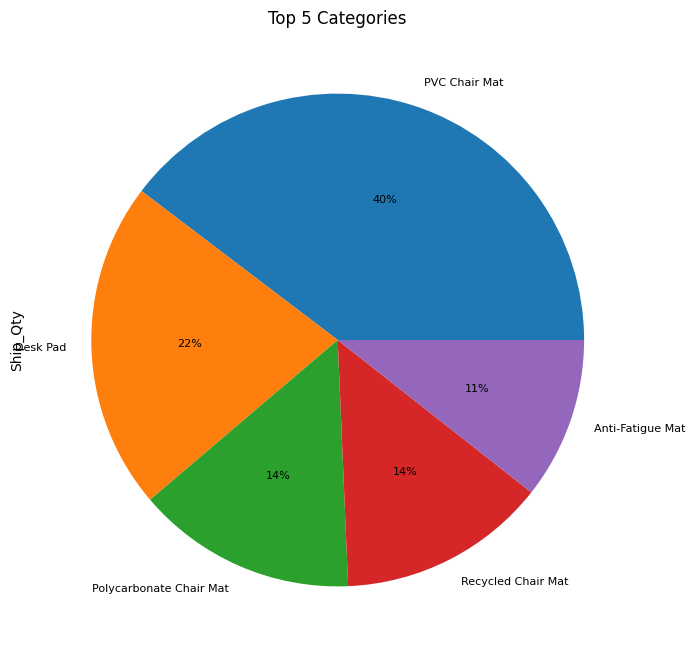

In [169]:
#top 5 categories
top_categories = merged_sales_product.groupby(['Category']).sum()['Ship_Qty'].nlargest(5)

# Create a pie chart for the top five categories
top_categories.plot(kind='pie', autopct='%1.0f%%', legend=False, fontsize=8)
plt.title('Top 5 Categories')
# Show the chart
plt.show()

* Dominant category: The largest slice of the pie chart belongs to the category labeled "PVC Chair Mat," accounting for 40% of sales.
* Other categories: The remaining four slices represent the following categories and their sales percentages:
    * Desk Pad: 22%
    * Anti-Fatigue Mat: 11%
    * Recycled Chair Mat: 14%
    * Polycarbonate Chair Mat: 14%

In [170]:
merged_sales_product['Profit'] = merged_sales_product['Extended_price'] - merged_sales_product['Current Cost']

In [171]:
selected_columns = ['Year', 'Month', 'Category', 'Ship_Qty', 'Profit', 'Extended_price', 'Margin_%_(Current)', 'Current Cost','On Hand','Unit_Price','Invoice_Date']
selected_sales = merged_sales_product[selected_columns]

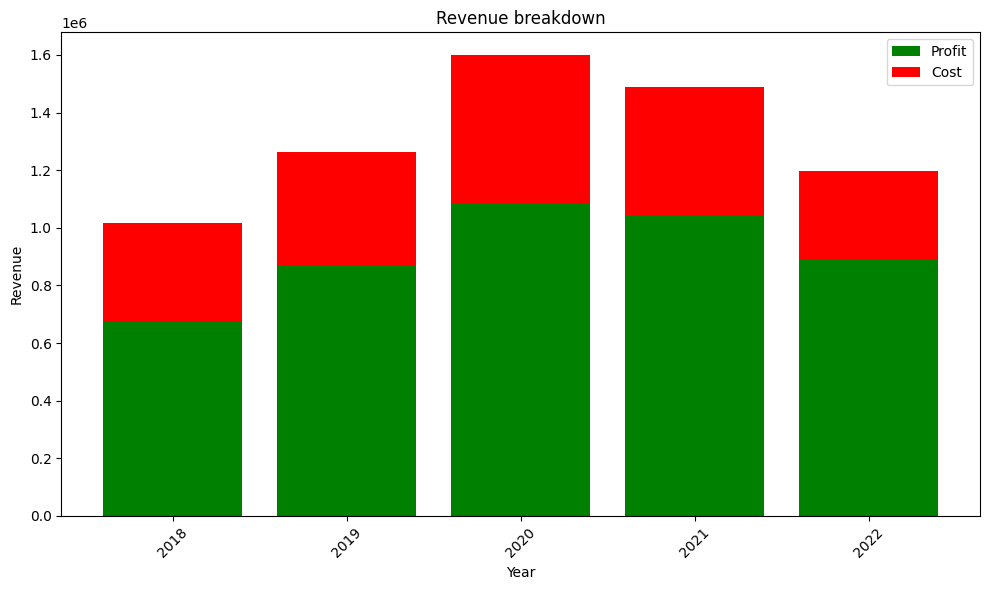

In [172]:
# Assuming you have a 'Profit' column in your selected_sales dataframe
monthly_data = selected_sales.groupby(['Year']).agg({'Current Cost': 'sum', 'Profit': 'sum'}).reset_index()

# Plotting the bar chart
plt.figure(figsize=(10, 6))

# Plotting Profit
plt.bar( monthly_data['Year'].astype(str),
        monthly_data['Profit'], label='Profit', color='green')

# Plotting Cost
plt.bar(monthly_data['Year'].astype(str),
        monthly_data['Current Cost'], label='Cost', bottom=monthly_data['Profit'], color='red')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('Revenue breakdown')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

The graph shows that the business made a profit steadily increasing over the past three years in 2018, 2019 and 2020. The most profitable years in 2022.

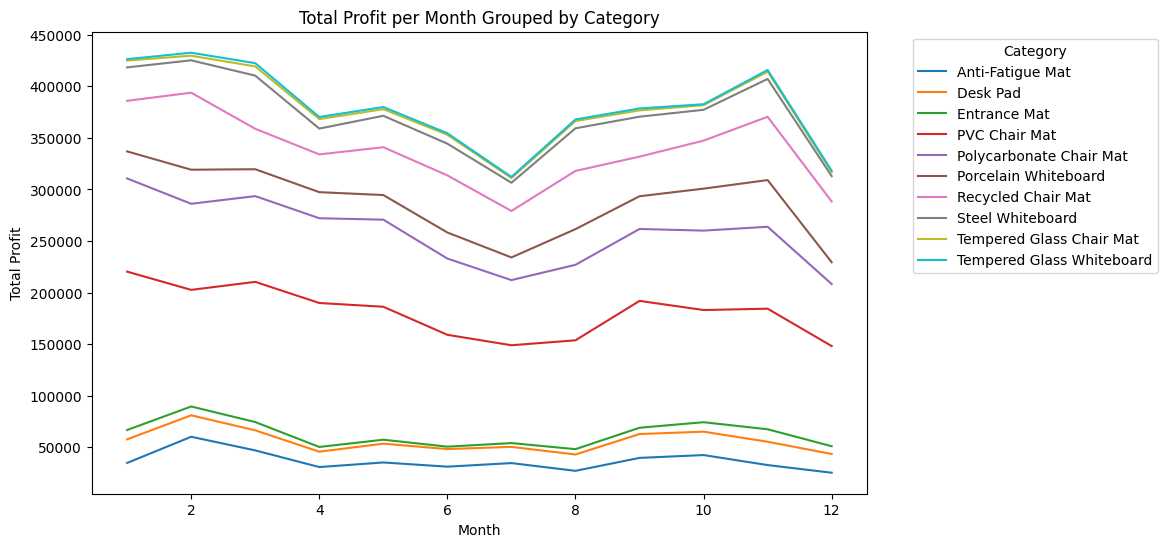

In [173]:
grouped_sales = selected_sales.groupby(['Month', 'Category']).sum()['Profit'].unstack()

# Plotting the bar graph
grouped_sales.plot(kind='line', stacked=True, figsize=(10, 6))
plt.title('Total Profit per Month Grouped by Category')
plt.xlabel('Month')
plt.ylabel('Total Profit')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

The graph shows the total profit per month for a company, grouped by category. The data appears to be for the year 2018-2022. Here are some insights based on the graph:

Overall, the company's profitability seems to be increasing. The total profit per month is trending upwards throughout the year. This suggests that the company's strategies are working and that it is on track to meet its financial goals.
PVC chair mats are the most profitable product category. They generate significantly more profit than any other category. This suggests that the company should focus on marketing and promoting anti-fatigue mats even more.
Desk pads, entrance mats, and Anti-fatigue mats are also relatively profitable. The company may want to consider investing in these product categories as well.
The least profitable product categories are polycarbonate chair mats, porcelain whiteboards, recycled chair mats, steel whiteboards, tempered glass chair mats, and tempered glass whiteboards. The company may want to consider discontinuing these product categories or finding ways to make them more profitable.

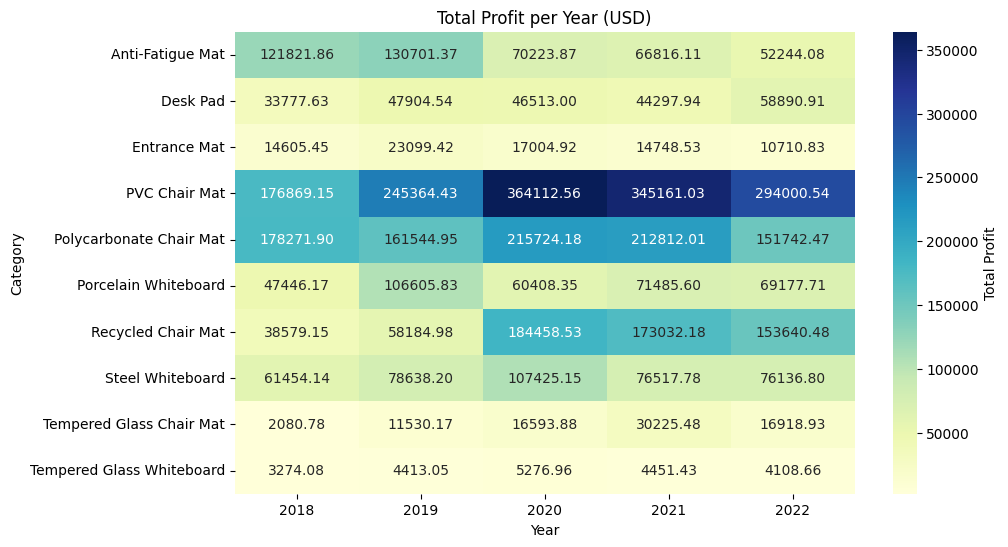

In [174]:
pivot_table_yearly = pd.pivot_table(selected_sales, values='Profit', index='Category', columns='Year', aggfunc='sum', fill_value=0)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_yearly, cmap='YlGnBu', annot=True, fmt=".2f", cbar_kws={'label': 'Total Profit'})
plt.title('Total Profit per Year (USD)')
plt.xlabel('Year')
plt.ylabel('Category')

# Show the plot
plt.show()

*Overall profit has increases steadily over the past five years. This is a positive trend and business is doing well.

*PVC Chair Mat appears to be the most profitable product category. In 2020, it generated a total profit of $364112, which is significantly higher than any other category.

Some product categories, such as Porcelain Whiteborad and Tempered Glass Chair Mat, have seen a decline in profitability in recent years. This could be due to a number of factors, such as increased competition, changes in customer preferences, or rising costs.
*The largest decrease in profit from 2021 to 2022 was fro Anti-Fatigue mat, with decrease of $14.000.

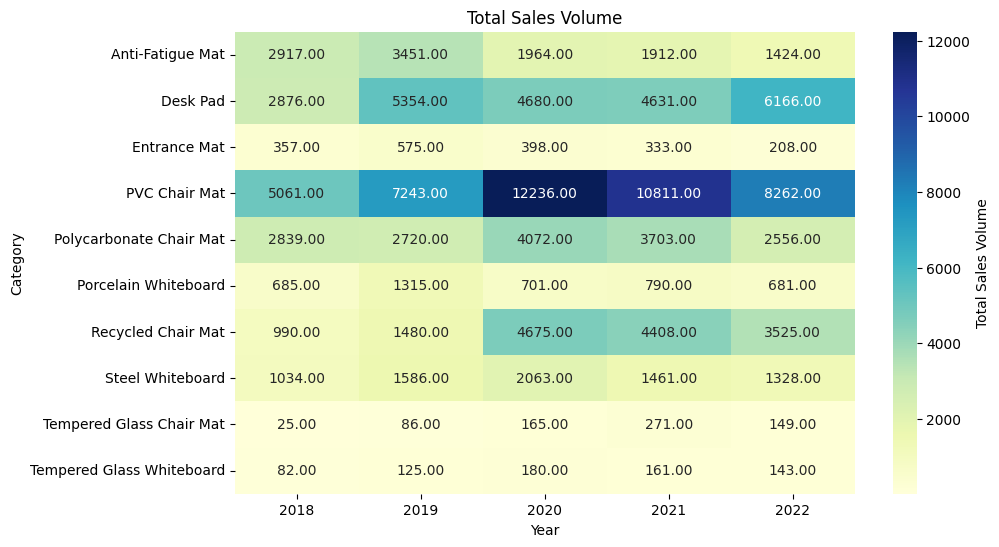

In [175]:
pivot_table_yearly_units = pd.pivot_table(selected_sales, values='Ship_Qty', index='Category', columns='Year', aggfunc='sum', fill_value=0)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table_yearly_units, cmap='YlGnBu', annot=True, fmt=".2f", cbar_kws={'label': 'Total Sales Volume'})
plt.title('Total Sales Volume')
plt.xlabel('Year')
plt.ylabel('Category')

# Show the plot
plt.show()

* Desk Pad: This product seems to have consistently high sales volume compared to others.
* PVC Chair Mat: This product also has relatively high sales volume, but it shows a significant drop in 2022.
* Tempered Glass Chair Mat and Tempered Glass Whiteboard: These products have the lowest sales volume among those listed

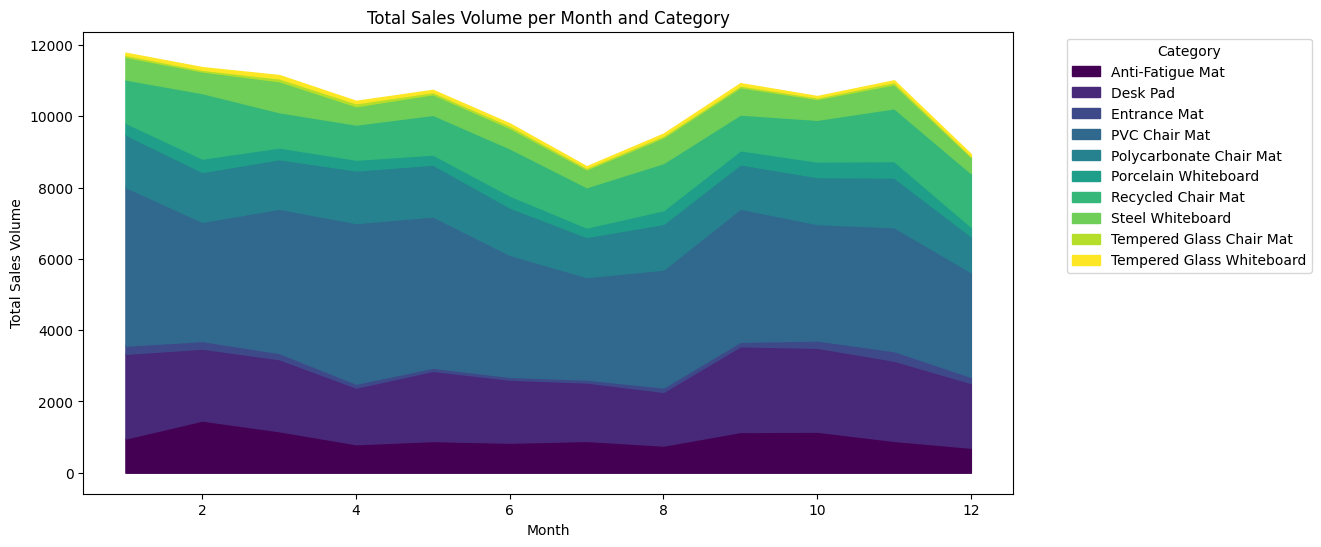

In [176]:
grouped_sales_volume = selected_sales.groupby(['Month', 'Category']).sum()['Ship_Qty'].unstack().reset_index()

# Melt the DataFrame to have 'Month', 'Category', and 'Ship_Qty' as columns
melted_df = pd.melt(grouped_sales_volume, id_vars='Month', var_name='Category', value_name='Ship_Qty')

# Create an area plot using stackplot with different colors for each category
plt.figure(figsize=(12, 6))

# Get unique categories and assign a different color to each category
categories = melted_df['Category'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))

# Create a list of arrays for each category
data_arrays = [melted_df[melted_df['Category'] == cat]['Ship_Qty'].values for cat in categories]

# Stack arrays vertically
stacked_data = np.vstack(data_arrays)

# Plot each category with a different color
for i in range(len(categories)):
    plt.fill_between(melted_df['Month'].unique(), stacked_data[:i+1].sum(axis=0), stacked_data[:i].sum(axis=0), color=colors[i], label=categories[i])

plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Total Sales Volume per Month and Category')
plt.xlabel('Month')
plt.ylabel('Total Sales Volume')

# Show the plot
plt.show()

* Overall, sales volume appears to be highest in the months of January,Feburary and March. This could be due to a number of factors, such as seasonality, marketing campaigns, or new product releases.
* There is a significant dip in sales volume in the month of May to July and November to December. This is likely due to the holiday season, when many businesses experience a slowdown in sales.
* The category of Anti-Fatigue Mats appears to have the most consistent sales volume throughout the year. This suggests that there is steady demand for this product category, regardless of the season.
* The category of Steel Whiteboards appears to have the most volatile sales volume. This could be due to the fact that this product is typically purchased by businesses, which may have more variable purchasing patterns than consumers.

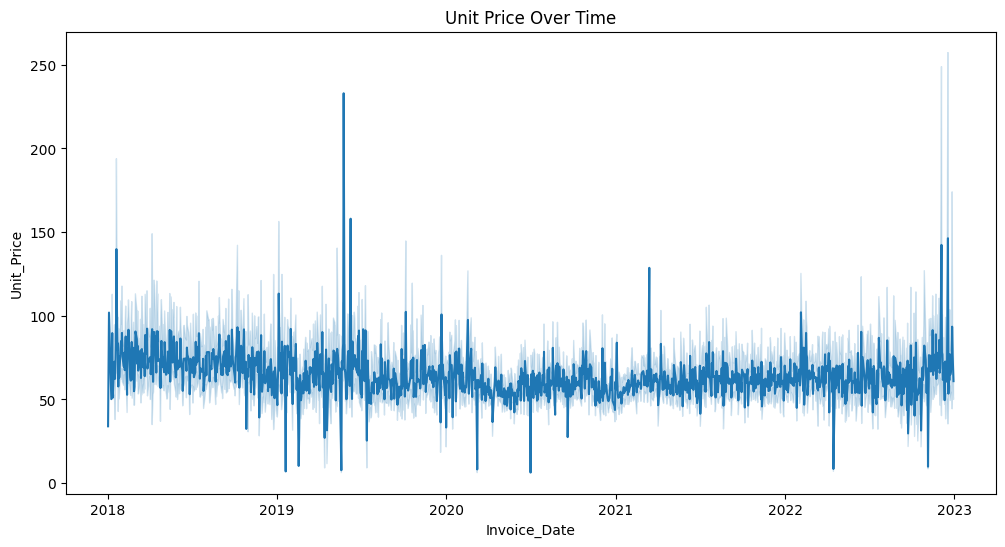

In [177]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Invoice_Date', y='Unit_Price', data=merged_sales_product)
plt.title('Unit Price Over Time')
plt.show()

The line plot visualizes
* The unit price has been increasing steadily over time. From 2018 to 2023, the unit price has increased from around 50 to around 250.
* There have been a few significant fluctuations in the unit price over time. For example, the price spiked in 2019 and then again in 2020 and 2022
* There have been some small fluctuations in the price, but the overall trend is upward.
* The largest increase in price was in 2019.

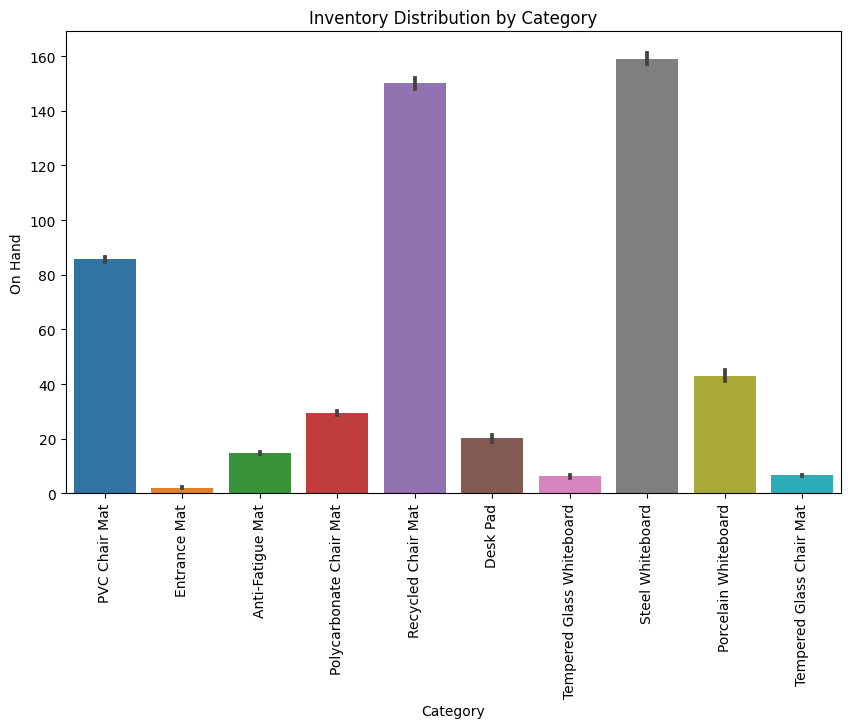

In [178]:
# Inventory Analysis
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='On Hand', data=merged_sales_product)
plt.title('Inventory Distribution by Category')
plt.xticks(rotation='vertical')
plt.show()

The box plot visualizes the distribution of on-hand quantities based on the availability status of products (e.g., available, unavailable).
Inventory management decisions, such as Enrance mat need to restock priorities or Steel Whiteboard have to identify slow-moving products.

# Feature engineering

In [17]:
# Select the columns needed for the model
sales=df_sales[['Invoice_Date', 'Ship_Qty', 'Part_No']]

# Display the dataframe
sales.head()

,Invoice_Date,Ship_Qty,Part_No
0,2018-01-02,1,123HarPVC20LV
1,2018-01-04,1,FPRPreEnt72CH
2,2018-01-09,2,FCOCoAnt36BK
3,2018-01-11,2,111AllPol23ER
4,2018-01-11,4,111MedPol23ER


In [18]:
# Display the datatypes
sales.dtypes

Invoice_Date    datetime64[ns]
Ship_Qty                 int64
Part_No                 object
dtype: object

In [19]:
# Select the columns needed for the model
products=df_product[['Category', 'Part_No']]

# Display the dataframe
products.head()

,Category,Part_No
0,Polycarbonate Chair Mat,111MedPol009R
1,Polycarbonate Chair Mat,111MedPol9RBL
2,Polycarbonate Chair Mat,111MedPol09RC
3,Polycarbonate Chair Mat,111MedPol23LR
4,Polycarbonate Chair Mat,111AllPol23ER


In [20]:
# Merge the dataframes
sales=pd.merge(sales, products)

# Display the dataframe
sales.head()

,Invoice_Date,Ship_Qty,Part_No,Category
0,2018-01-02,1,123HarPVC20LV,PVC Chair Mat
1,2018-01-19,1,123HarPVC20LV,PVC Chair Mat
2,2018-01-19,1,123HarPVC20LV,PVC Chair Mat
3,2018-01-22,1,123HarPVC20LV,PVC Chair Mat
4,2018-01-22,1,123HarPVC20LV,PVC Chair Mat


In [21]:
# Convert to datetime format
sales['Date']=pd.to_datetime(sales['Invoice_Date'])

# Display the datatypes
sales.dtypes

Invoice_Date    datetime64[ns]
Ship_Qty                 int64
Part_No                 object
Category                object
Date            datetime64[ns]
dtype: object

In [22]:
# extract year, month and day values from the 'Date' column
sales['year'] = sales['Date'].dt.year
sales['month'] = sales['Date'].dt.month
sales['day'] = sales['Date'].dt.day

# Display the dataframe
sales.head()

,Invoice_Date,Ship_Qty,Part_No,Category,Date,year,month,day
0,2018-01-02,1,123HarPVC20LV,PVC Chair Mat,2018-01-02,2018,1,2
1,2018-01-19,1,123HarPVC20LV,PVC Chair Mat,2018-01-19,2018,1,19
2,2018-01-19,1,123HarPVC20LV,PVC Chair Mat,2018-01-19,2018,1,19
3,2018-01-22,1,123HarPVC20LV,PVC Chair Mat,2018-01-22,2018,1,22
4,2018-01-22,1,123HarPVC20LV,PVC Chair Mat,2018-01-22,2018,1,22


In [23]:
# Check the datatypes
sales.dtypes

Invoice_Date    datetime64[ns]
Ship_Qty                 int64
Part_No                 object
Category                object
Date            datetime64[ns]
year                     int64
month                    int64
day                      int64
dtype: object

In [24]:
# Rename the column
sales.rename(columns = {'Ship_Qty':'Ship Quantity'}, inplace = True)

# Check the value counts
sales['Category'].value_counts()

PVC Chair Mat                31150
Polycarbonate Chair Mat       8987
Recycled Chair Mat            5544
Anti-Fatigue Mat              5228
Desk Pad                      4267
Steel Whiteboard              4178
Porcelain Whiteboard          2248
Entrance Mat                  1412
Tempered Glass Chair Mat       678
Tempered Glass Whiteboard      526
Name: Category, dtype: int64

In [25]:
print('Min date from train set: %s' % sales['Invoice_Date'].min().date())
print('Max date from train set: %s' % sales['Invoice_Date'].max().date())

Min date from train set: 2018-01-02
Max date from train set: 2022-12-30


In [26]:
# Create a new dataframe by filtering for one category
product_1=sales.loc[(sales['Category']=='Anti-Fatigue Mat')]

# Display the dataframe
product_1.head()

,Invoice_Date,Ship Quantity,Part_No,Category,Date,year,month,day
3263,2018-01-09,2,FCOCoAnt36BK,Anti-Fatigue Mat,2018-01-09,2018,1,9
3264,2018-01-12,2,FCOCoAnt36BK,Anti-Fatigue Mat,2018-01-12,2018,1,12
3265,2018-01-17,1,FCOCoAnt36BK,Anti-Fatigue Mat,2018-01-17,2018,1,17
3266,2018-01-17,2,FCOCoAnt36BK,Anti-Fatigue Mat,2018-01-17,2018,1,17
3267,2018-01-17,2,FCOCoAnt36BK,Anti-Fatigue Mat,2018-01-17,2018,1,17


In [27]:
# SELECT THE CATEGORY:
"""PVC Chair Mat                31150
Polycarbonate Chair Mat       8987
Recycled Chair Mat            5544
Anti-Fatigue Mat              5228
Desk Pad                      4267
Steel Whiteboard              4178
Porcelain Whiteboard          2248
Entrance Mat                  1412
Tempered Glass Chair Mat       678
Tempered Glass Whiteboard      526
Sales
"""
category='Sales'

# Create a function to filter the dataframe for the selected category
def dataframe(category):
    prod=sales.loc[(sales['Category']==category)]
    pro=prod.groupby(pd.to_datetime(prod['Date']).dt.strftime('%y-%m'))['Ship Quantity'].sum()
    pro=pd.DataFrame(pro)
    return pro

if (category != 'Sales'):
    pro=dataframe(category)
else:
    pro=sales.groupby(pd.to_datetime(sales['Date']).dt.strftime('%y-%m'))['Ship Quantity'].sum()
    pro=pd.DataFrame(pro)
pro.head()

,Ship Quantity
Date,
18-01,759
18-02,1533
18-03,1406
18-04,1212
18-05,1226


<Axes: xlabel='Date'>

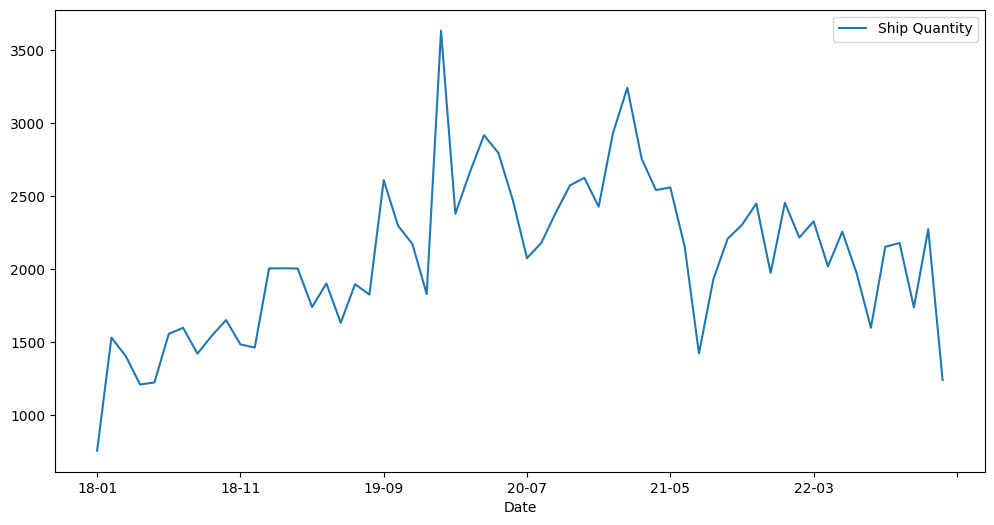

In [28]:
pro.plot(figsize=(12,6))

## Time Series Decomposition

### Without Differencing

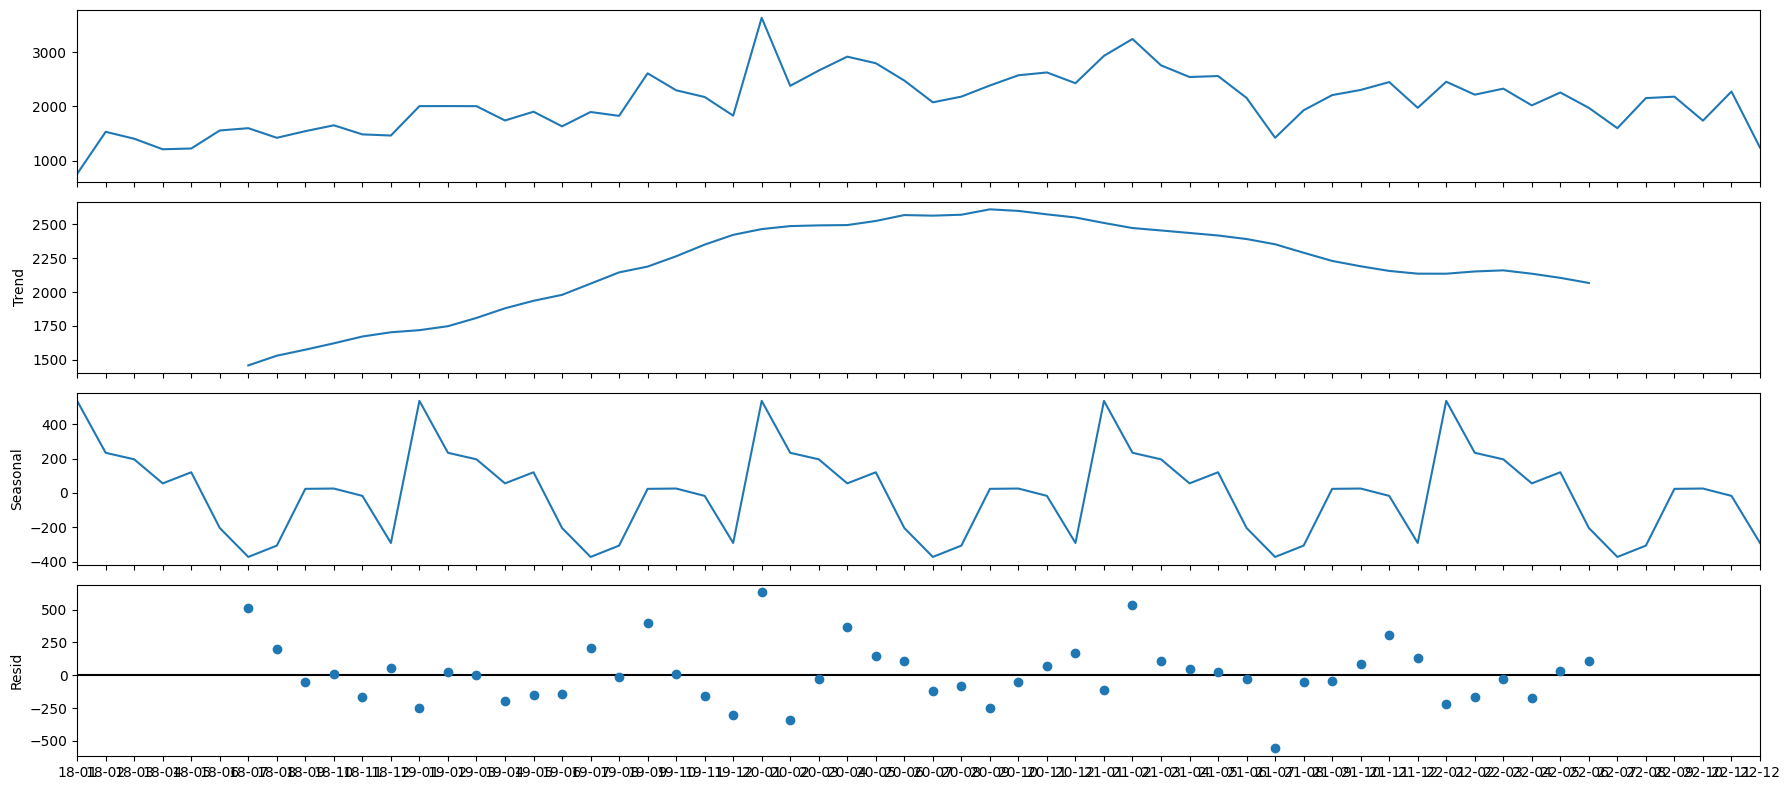

In [29]:
# Decompose the components from the time series.

# Create a graph to analyze decomposition
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(pro, model='additive', period=12)
fig = decomposition.plot()

# Show the chart
plt.show()

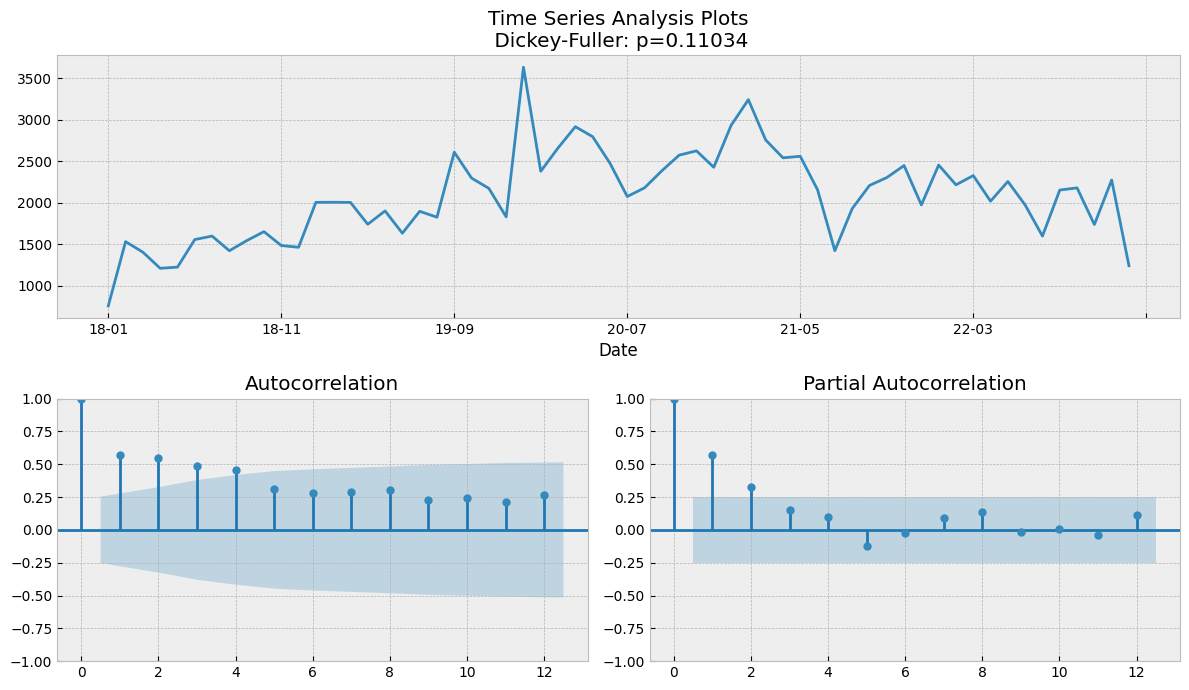

'Dickey-Fuller test:\n    H_0: The time series are not stationary (p_value >= 0.05)\n    H_1: Reject H_0 (p_value < 0.05)\n'

In [30]:
# ADF Test
# Create a function to plot time series analysis
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


tsplot(pro['Ship Quantity'], lags=12)

# Show the chart
plt.show()
"""Dickey-Fuller test:
    H_0: The time series are not stationary (p_value >= 0.05)
    H_1: Reject H_0 (p_value < 0.05)
"""

### First-Order Differencing

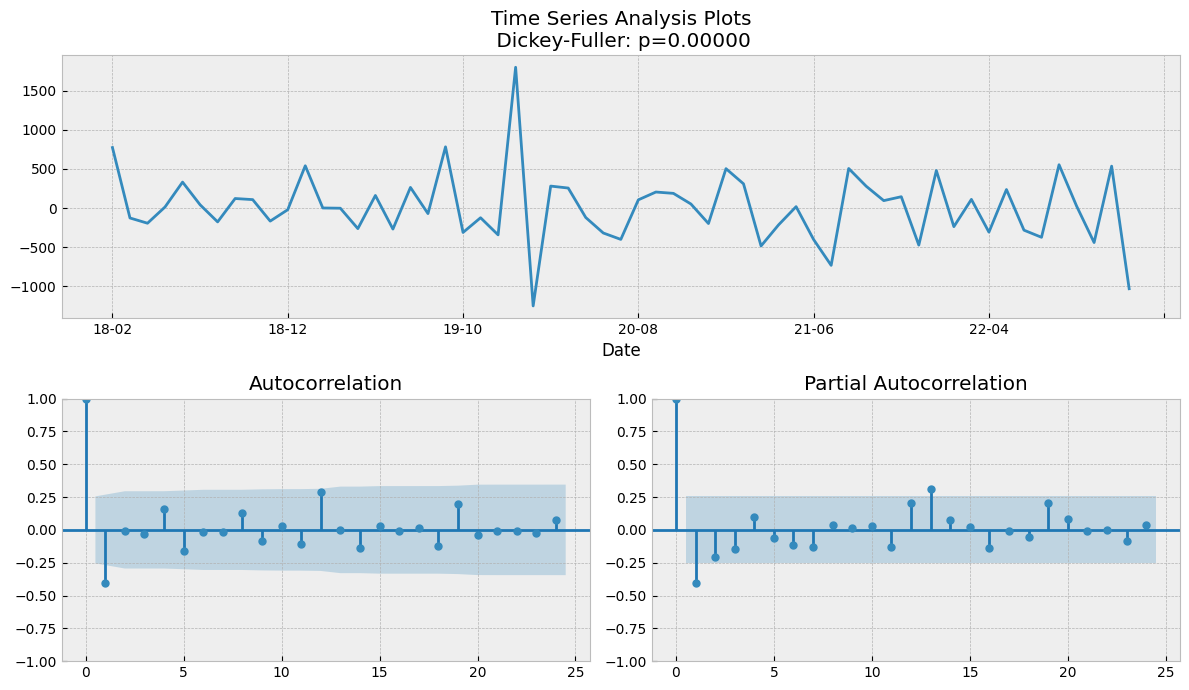

In [31]:
# Craete a chart to show time series analysis after applying differencing method
pro_diff = pro['Ship Quantity'] - pro['Ship Quantity'].shift(1)
tsplot(pro_diff[1:], lags=24)

# Modeling 1 : SARIMA

## Best Parameters SARIMA Model

In [32]:
# Divide the data into training and testing (4 years train and 1 year testing)
train = pro[:'22']
test = pro['22':]

# Display the testing data
test

,Ship Quantity
Date,
22-01,2455
22-02,2217
22-03,2328
22-04,2020
22-05,2257
22-06,1974
22-07,1600
22-08,2154
22-09,2180


In [33]:
# Create a function to generate AIC scores, and choose parameters based on AIC socres
def optimizeSARIMA(parameters_list, s):
    """Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, d, q, P, D, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(train['Ship Quantity'], order=(param[0], param[1], param[2]),
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic

        # Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']

    # Sort in ascending order, the lower the AIC is - the better the model is
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

# Set the initial parameters for the SARIMAX model and some bounds for them
ps = range(0, 3)
ds = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
Ds = range(0, 1)
Qs = range(0, 2)
s = 12 # season length is still 12

# Create a list with all the possible combinations of parameters
parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
warnings.filterwarnings("ignore")
result_table = optimizeSARIMA(parameters_list, s)

# Show the dataframe with parameters and AIC scores
result_table.head()

  0%|          | 0/108 [00:00<?, ?it/s]

,parameters,aic
0,"(0, 1, 1, 0, 0, 1)",697.156454
1,"(0, 1, 1, 1, 0, 0)",697.705893
2,"(0, 1, 1, 2, 0, 0)",699.072669
3,"(1, 1, 1, 0, 0, 1)",699.142650
4,"(0, 1, 2, 0, 0, 1)",699.143229


## Model Training

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6608      0.136     -4.864      0.000      -0.927      -0.394
ma.S.L12       0.4379      0.168      2.603      0.009       0.108       0.768
sigma2      1.232e+05   2.31e+04      5.323      0.000    7.78e+04    1.69e+05


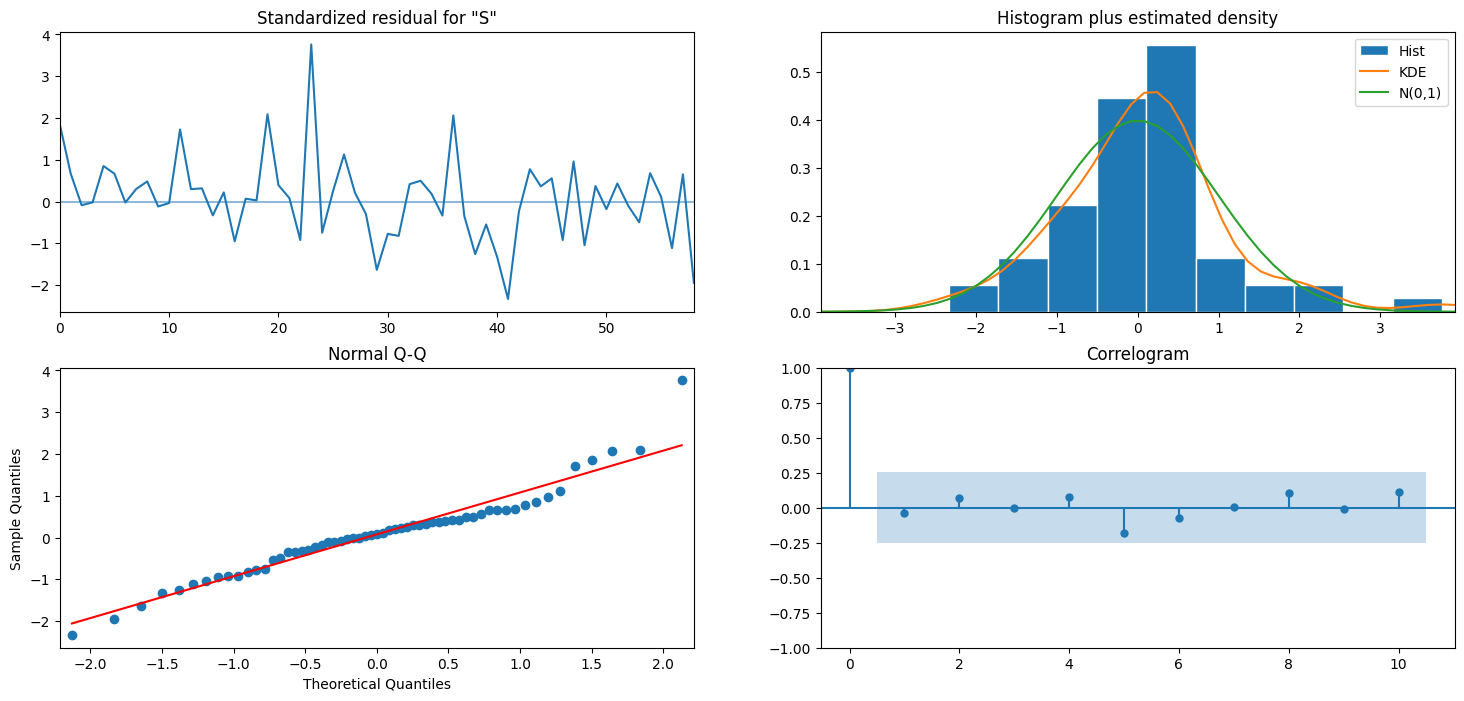

In [34]:
# Set the parameters that give the lowest AIC
p, d, q, P, D, Q = result_table.parameters[0]

# Craete a chart to show diagnostics
best_model=sm.tsa.statespace.SARIMAX(pro, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary().tables[1])

best_model.plot_diagnostics(figsize=(18, 8))
plt.show()

In [35]:
# Create a function to calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Model Evaluation

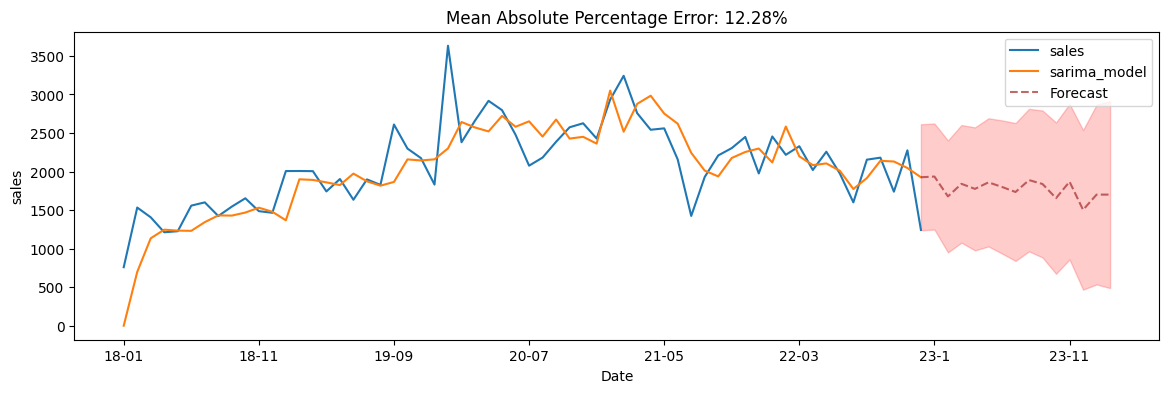

In [36]:

# Craete a function for the SARIMAX model to show predictions
def plotSARIMAX(series, model, n_steps, category):
    """Plots model vs predicted values
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        category - name of the numerical data
    """
    # adding model values
    data = series.copy()
    data.columns = [category]
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    #data['sarima_model'][:s] = np.NaN

    date_scale=[['23-1', ''],['23-2', ''],['23-3', ''],['23-4', ''],['23-5', ''],['23-6', ''],['23-7', ''],['23-8', ''],['23-9', ''],['23-10', ''],['23-11', ''],['23-12', '']]
    date_scale_df=pd.DataFrame(date_scale, columns=['Date', category])
    date_scale_df=date_scale_df.set_index(['Date'])
    data=data.append(date_scale_df)

    error = mean_absolute_percentage_error(data[category][s+d:], data['sarima_model'][s+d:])

    prediction = model.get_prediction(start=data.shape[0]-n_steps-1, end = data.shape[0]+1, dynamic=False)
    data[category][60:] = np.NaN
    pred_conf_int = prediction.conf_int(alpha=0.05)
    data_graph = data.plot()
    prediction.predicted_mean.plot(ax=data_graph, label='Forecast', alpha=.7, figsize=(14, 4), color='brown', linestyle='dashed')
    data_graph.fill_between(pred_conf_int.index,
                pred_conf_int.iloc[:, 0],
                pred_conf_int.iloc[:, 1], color='red', alpha=.2)
    data_graph.set_xlabel('Date')
    data_graph.set_ylabel(category)
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    #plt.grid()
    plt.legend()
    plt.show()

# Plot the model
plotSARIMAX(pro, best_model, 12, 'sales')

# Modeling 2 : LSTM

## Model Training

In [210]:
# Preprocessing data, scaling data or convert the data in to 0 to 1
scaler = MinMaxScaler()

In [211]:
# Scaling Train and Test Data
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [212]:
scaled_train[:5]

array([[0.        ],
       [0.2694048 ],
       [0.22520014],
       [0.1576749 ],
       [0.16254786]])

In [213]:
scaled_test[:5]

array([[0.5903237 ],
       [0.50748347],
       [0.54611904],
       [0.43891403],
       [0.5214062 ]])

In [214]:
# define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [215]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.        0.2694048]
Predict this y: 
 [[0.22520014]]


In [216]:
X.shape

(1, 2, 1)

In [217]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [218]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mape')

In [219]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               40800     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [220]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
36/36 [==============================] - 2s 26ms/step - loss: 44.9464
Epoch 2/50
36/36 [==============================] - 1s 25ms/step - loss: 22.5836
Epoch 3/50
36/36 [==============================] - 1s 16ms/step - loss: 21.7214
Epoch 4/50
36/36 [==============================] - 1s 14ms/step - loss: 21.8858
Epoch 5/50
36/36 [==============================] - 1s 15ms/step - loss: 22.4810
Epoch 6/50
36/36 [==============================] - 1s 14ms/step - loss: 22.1324
Epoch 7/50
36/36 [==============================] - 1s 15ms/step - loss: 21.1927
Epoch 8/50
36/36 [==============================] - 1s 14ms/step - loss: 24.9756
Epoch 9/50
36/36 [==============================] - 1s 15ms/step - loss: 20.7034
Epoch 10/50
36/36 [==============================] - 1s 15ms/step - loss: 20.6807
Epoch 11/50
36/36 [==============================] - 1s 15ms/step - loss: 20.8052
Epoch 12/50
36/36 [==============================] - 1s 15ms/step - loss: 19.8233
Epoch 13/50
36/36 [======

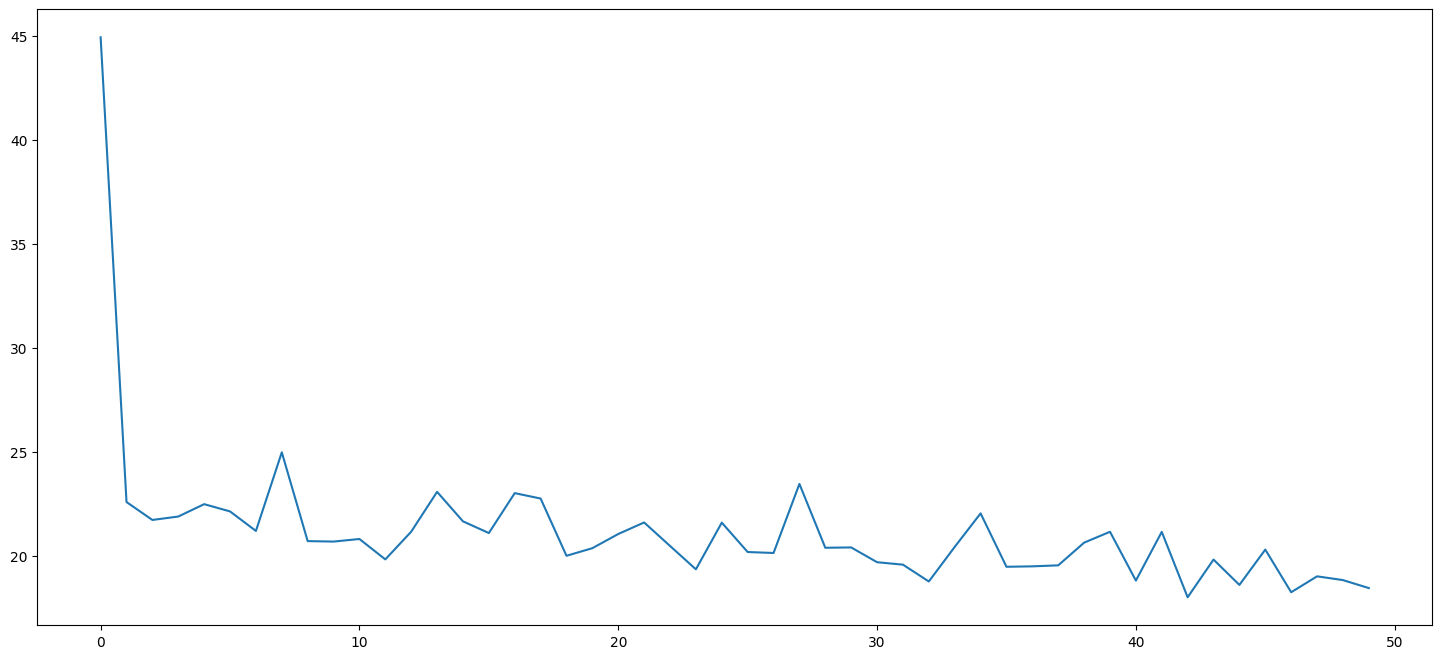

In [221]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [224]:
# mengambil data 12 bulan terakhir pada train set untuk predict first value in test set
last_train_batch = scaled_train[-12:]

In [225]:
# reshape the data like how the model has been trained
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [226]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 214ms/step


array([[0.542734]], dtype=float32)

In [227]:
scaled_test[0]

array([0.5903237])

## Model Evaluation

In [229]:
test_predictions = []

#take the last 12 values in training set
first_eval_batch = scaled_train[-n_input:]
#reshaping
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 57ms/step


In [230]:
test_predictions

[array([0.542734], dtype=float32),
 array([0.5788748], dtype=float32),
 array([0.5586977], dtype=float32),
 array([0.5437042], dtype=float32),
 array([0.5370298], dtype=float32),
 array([0.5129582], dtype=float32),
 array([0.48628998], dtype=float32),
 array([0.4950586], dtype=float32),
 array([0.50753164], dtype=float32),
 array([0.51453495], dtype=float32),
 array([0.5215487], dtype=float32),
 array([0.50579816], dtype=float32)]

In [231]:
true_predictions = scaler.inverse_transform(test_predictions)

In [232]:
test['Predictions'] = true_predictions

In [233]:
test.head()

,Ship Quantity,Predictions
Date,,
22-01,2455,2318.274859
22-02,2217,2422.107376
22-03,2328,2364.138494
22-04,2020,2321.062200
22-05,2257,2301.886623


<Axes: xlabel='Date'>

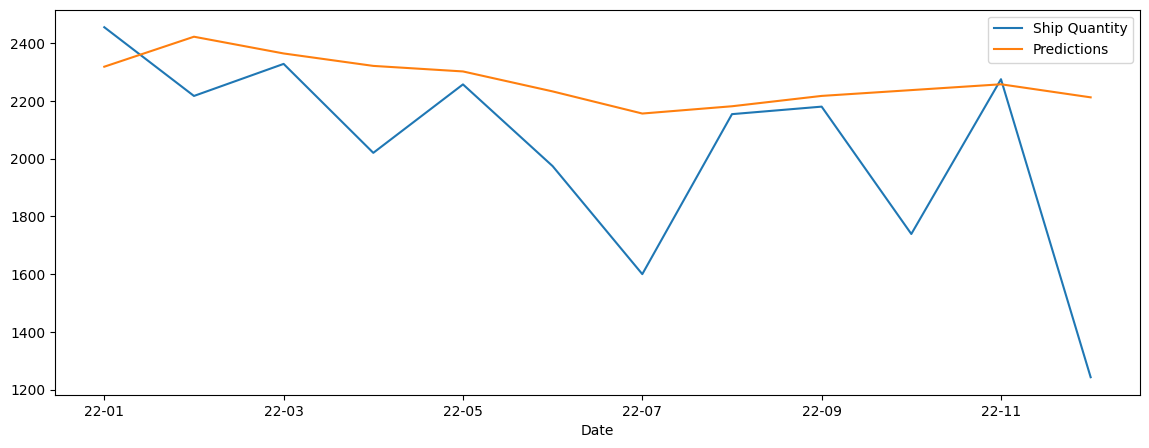

In [234]:
test.plot(figsize=(14,5))

In [236]:
# Check the MAE & RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MAE test  : ', mean_absolute_error(test['Ship Quantity'],test['Predictions']))
print('MAPE test  : ', mean_absolute_percentage_error(test['Ship Quantity'],test['Predictions']))
print('RMSE test : ', np.sqrt(mean_squared_error(test['Ship Quantity'],test['Predictions'])))

MAE test  :  257.35077796379727
MAPE test  :  15.957956751698744
RMSE test :  378.6913721916565


# Modeling 3 : Linear Regression

In [237]:
pro.to_csv('pro.csv')

In [240]:
#Load data
df = pd.read_csv('pro.csv')
df.head()

,Date,Ship Quantity
0,18-01,759
1,18-02,1533
2,18-03,1406
3,18-04,1212
4,18-05,1226


In [241]:
sales = df.set_index('Date')['Ship Quantity']
sales.head(), sales.tail()

(Date
 18-01     759
 18-02    1533
 18-03    1406
 18-04    1212
 18-05    1226
 Name: Ship Quantity, dtype: int64,
 Date
 22-08    2154
 22-09    2180
 22-10    1739
 22-11    2275
 22-12    1243
 Name: Ship Quantity, dtype: int64)

In [243]:
# Penentuan fitur dan target
window = 12
X = []
y = []
for i in range(window,len(sales)):
  if window+i<len(sales):
    X.append(sales[i:window+i].values.tolist())
    try:
      y.append(sales[window+i])
    except:
      pass
  else:
    break

X = np.array(X)
y = np.array(y)

In [244]:
X

array([[2006, 2007, 2005, 1742, 1903, 1634, 1898, 1827, 2610, 2298, 2174,
        1831],
       [2007, 2005, 1742, 1903, 1634, 1898, 1827, 2610, 2298, 2174, 1831,
        3632],
       [2005, 1742, 1903, 1634, 1898, 1827, 2610, 2298, 2174, 1831, 3632,
        2380],
       [1742, 1903, 1634, 1898, 1827, 2610, 2298, 2174, 1831, 3632, 2380,
        2661],
       [1903, 1634, 1898, 1827, 2610, 2298, 2174, 1831, 3632, 2380, 2661,
        2917],
       [1634, 1898, 1827, 2610, 2298, 2174, 1831, 3632, 2380, 2661, 2917,
        2796],
       [1898, 1827, 2610, 2298, 2174, 1831, 3632, 2380, 2661, 2917, 2796,
        2477],
       [1827, 2610, 2298, 2174, 1831, 3632, 2380, 2661, 2917, 2796, 2477,
        2076],
       [2610, 2298, 2174, 1831, 3632, 2380, 2661, 2917, 2796, 2477, 2076,
        2181],
       [2298, 2174, 1831, 3632, 2380, 2661, 2917, 2796, 2477, 2076, 2181,
        2386],
       [2174, 1831, 3632, 2380, 2661, 2917, 2796, 2477, 2076, 2181, 2386,
        2574],
       [1831, 3632, 2

In [245]:
train_size = round(len(X)*0.8)
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

<Axes: xlabel='Date'>

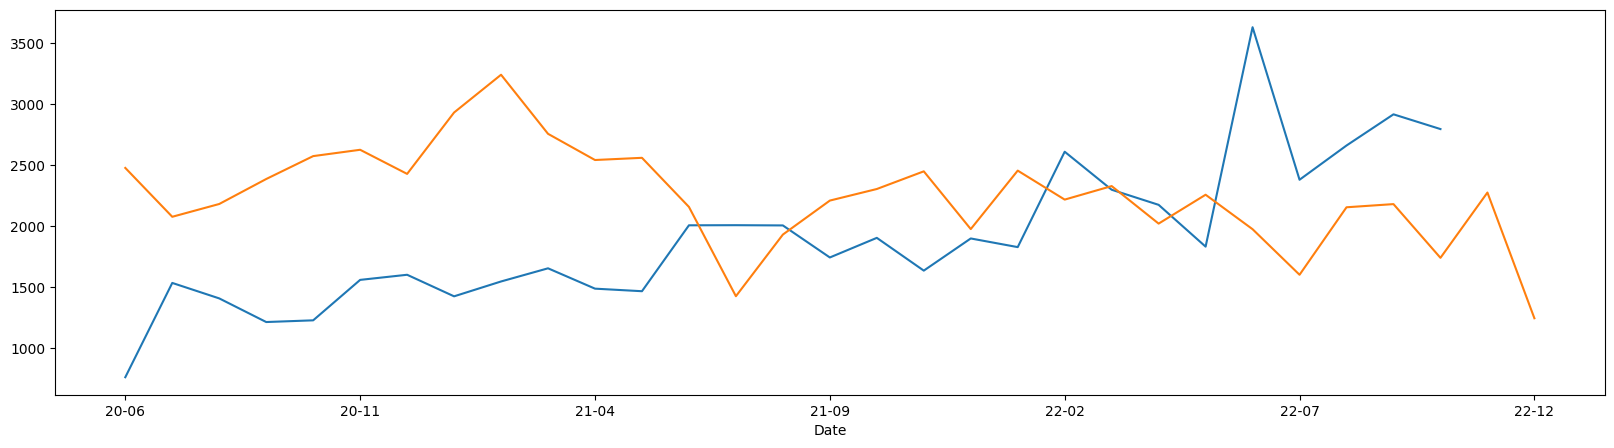

In [246]:
sales[:train_size].plot(figsize=(20,5))
sales[train_size:].plot(figsize=(20,5))

In [248]:
#Scaling Train and Test data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training

In [252]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X_train_scaled,y_train)

y_pred_train = model_lr.predict(X_train_scaled)
y_pred_test = model_lr.predict(X_test_scaled)

## Model Evaluation

In [253]:
print('Train MAE:',mean_absolute_error(y_train,y_pred_train))
print('Test MAE:',mean_absolute_error(y_test,y_pred_test))
print('Train MAPE:',mean_absolute_percentage_error(y_train,y_pred_train))
print('Test MAPE:',mean_absolute_percentage_error(y_test,y_pred_test))

Train MAE: 251.8992663980225
Test MAE: 678.5942186864899
Train MAPE: 10.706952101066488
Test MAPE: 42.2966875295173


<Axes: xlabel='Date'>

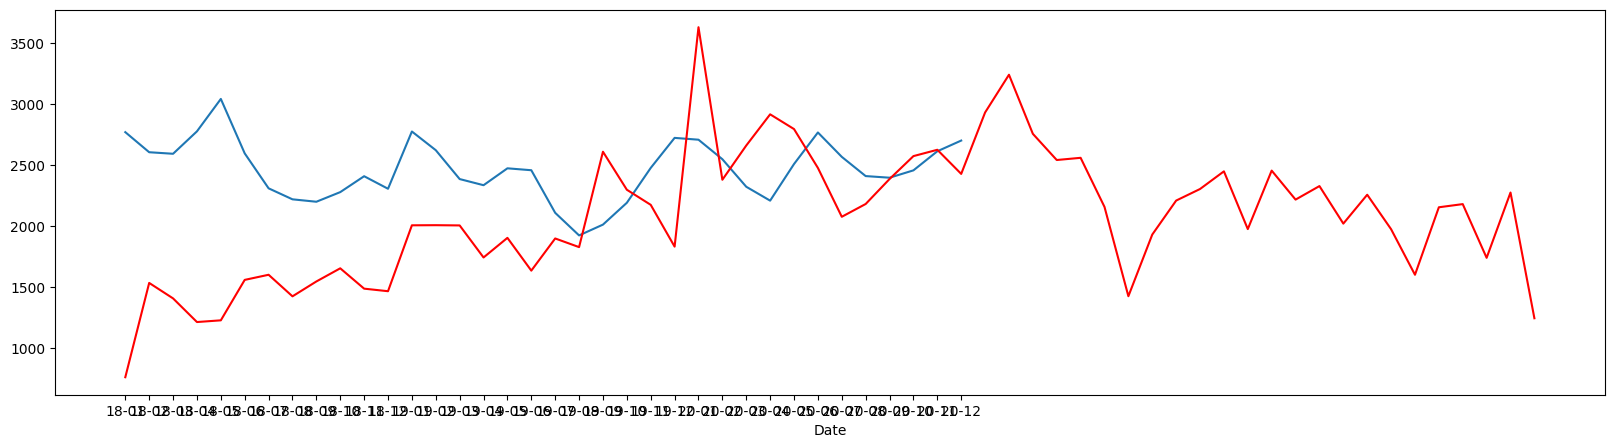

In [255]:
import matplotlib.pyplot as plt

plt.plot(sales.index[window:-window],np.append(y_pred_train,y_pred_test))
sales.plot(color='red', figsize=(20,5))

# Model Saving

In [254]:
# Save scaler dan model

with open ('scaler.pkl', 'wb') as file1:
  pickle.dump(scaler, file1)

with open ('model.pkl', 'wb') as file1:
  pickle.dump(model_lr, file1)

# Model Inference

In [257]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

def forecasting(month):
    sales_forecast = sales.copy()
    window = 12
    for i in range(month):
        X = sales_forecast[-window:].values.reshape(1, -1)
        X_scaled = scaler.transform(X)

        last_month_str = sales_forecast.index[-1]
        last_month = datetime.strptime(last_month_str, '%y-%m')

        # Increment the month, handling overflow
        new_month = last_month + relativedelta(months=1)  # Increment by 1 month

        # Predict and round the sales value
        predicted_sales = round(model_lr.predict(X_scaled)[0])

        # Add a new row with the predicted sales and the new index
        sales_forecast = sales_forecast.append(pd.Series([predicted_sales], index=[new_month.strftime('%y-%m')], name='sales'))

    # Create a DateTime index using the 'Date' column
    sales_forecast.index = pd.to_datetime(sales_forecast.index, format='%y-%m')

    # Drop the 'Date' column
    sales_forecast = sales_forecast.drop(columns=['Date'])

    return sales_forecast




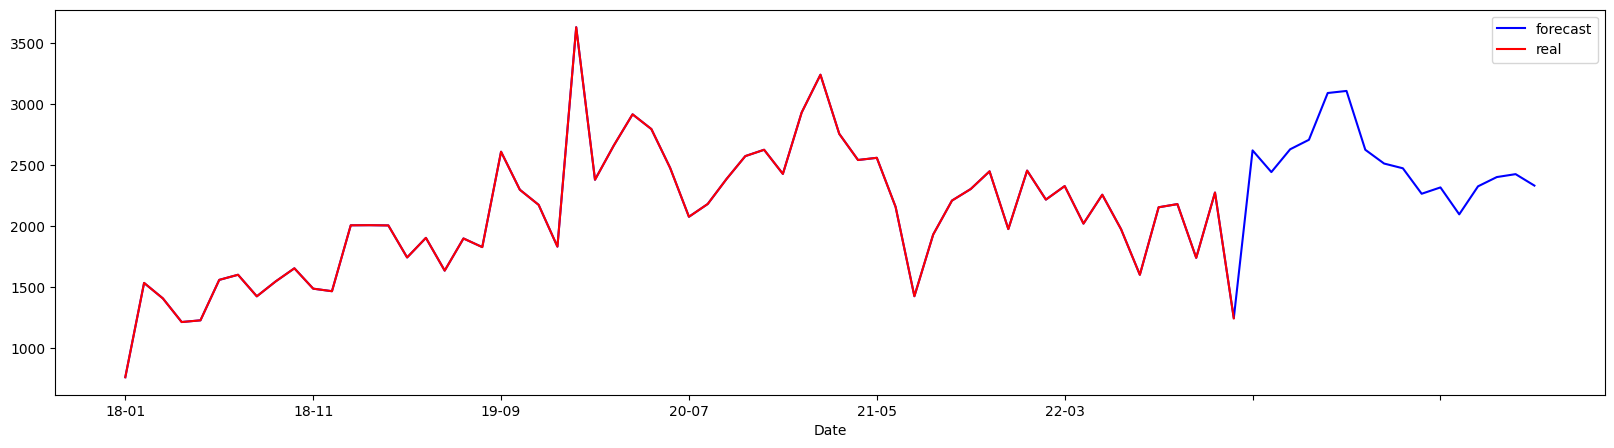

In [258]:
sales_forecast = forecasting(16)
sales_forecast.index = sales_forecast.index.strftime('%y-%m')  # Convert Periods to strings
sales_forecast.plot(color='blue', label='forecast', figsize=(20, 5))

# Convert PeriodIndex to strings
sales.index = sales.index.astype(str)
sales.plot(color='red', label='real')

plt.legend()
plt.show()

In [259]:
print(sales_forecast)

18-01     759
18-02    1533
18-03    1406
18-04    1212
18-05    1226
         ... 
23-12    2096
24-01    2326
24-02    2402
24-03    2426
24-04    2332
Length: 76, dtype: int64


# Conclusion

In our project, we created a forecasting model to estimate the future sales of a distribution company. This model was based on an analysis of the historical sales (unit sales volume) over for 5 year period (2018 - 2022).

From three models : SARIMA, LSTM, Linear Regression, the best model is Linear Regression with 10% the value of evaluation result using MAPE.

The result of data inference

Prediction of Sales Quantity for Q1 in 2024 :

January 2024  =  2326 products

Feburary 2024 =   2402 products

March =  2426 products

April =  2332 products


The mean absolute percentage error (MAPE), with a 10% MAPE representing the average deviation between the forecasted value and actual values was 10%, regardless of whether the deviation was positive or negative. For example, in January 2024 the prediction Sales Quantity are 2326 products + 10% error so the company need increse or decrese the production quantity about 10% (233 products).



